In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [34]:
# Load the data
df = pd.read_excel("C:/Users/baner/Documents/Planet-Hunt/data/Study_of_exoplanets.xlsx")

# Data preprocessing
M = df.P_MASS.median()
df['P_MASS'] = df.P_MASS.fillna(M)
R = df.P_RADIUS.median()
df['P_RADIUS'] = df.P_RADIUS.fillna(R)
P = df.P_PERIOD.median()
df['P_PERIOD'] = df.P_PERIOD.fillna(P)
S = df.P_SEMI_MAJOR_AXIS.median()
df['P_SEMI_MAJOR_AXIS'] = df.P_SEMI_MAJOR_AXIS.fillna(S)
E = df.P_ECCENTRICITY.median()
df['P_ECCENTRICITY'] = df.P_ECCENTRICITY.fillna(E)
I = df.P_INCLINATION.median()
df['P_INCLINATION'] = df.P_INCLINATION.fillna(I)
Es = df.P_ESCAPE.median() 
df['P_ESCAPE'] = df.P_ESCAPE.fillna(Es)
Pot = df.P_POTENTIAL.median()
df['P_POTENTIAL'] = df.P_POTENTIAL.fillna(Pot)
G = df.P_GRAVITY.median()
df['P_GRAVITY'] = df.P_GRAVITY.fillna(G)
D = df.P_DENSITY.median()
df['P_DENSITY'] = df.P_DENSITY.fillna(D)

In [35]:
# Features and target variable
X = df[['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 
          'P_INCLINATION', 'P_ESCAPE', 'P_POTENTIAL', 'P_GRAVITY', 'P_DENSITY'
          ]]
          
y = df['P_HABITABLE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DL model
model = keras.Sequential([
    # Input layer
    keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),

    # Hidden layers
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    
    # Output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50


c:\Users\baner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9176 - loss: 0.7839 - val_accuracy: 0.9784 - val_loss: 0.1420
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0784 - val_accuracy: 0.9784 - val_loss: 0.1403
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0993 - val_accuracy: 0.9784 - val_loss: 0.1353
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0612 - val_accuracy: 0.9784 - val_loss: 0.1262
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0867 - val_accuracy: 0.9784 - val_loss: 0.1261
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0833 - val_accuracy: 0.9784 - val_loss: 0.1195
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0738 - val_accuracy: 0.9784 - val_loss: 0.1114
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0578 - val_accuracy: 0.9784 - val_loss: 0.1070
Epo

In [39]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.9846 - loss: 0.0646
Test accuracy: 0.9864


In [40]:
# Generate a classification report
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print(classification_report(y_test, y_pred, target_names=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable']))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
                          precision    recall  f1-score   support

           Uninhabitable       0.99      1.00      0.99       799
Conservatively Habitable       0.00      0.00      0.00         4
Optimistically Habitable       0.00      0.00      0.00         7

                accuracy                           0.99       810
               macro avg       0.33      0.33      0.33       810
            weighted avg       0.97      0.99      0.98       810



c:\Users\baner\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\baner\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\baner\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

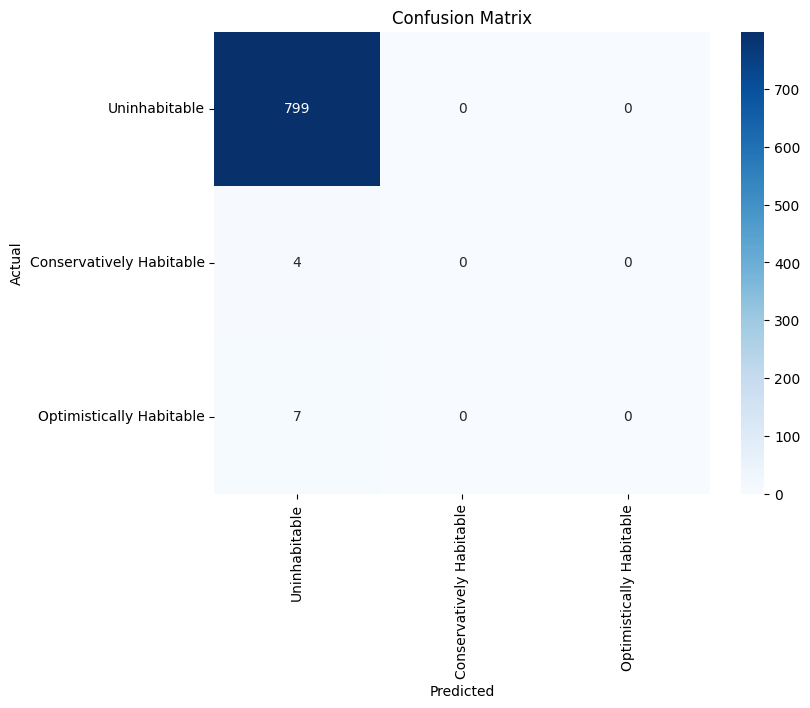

In [41]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'], 
            yticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()